Este notebook junta todos los datos que tenemos disponibles para un primer modelo

Modelo base
- Fecha
- Hora
- Histórico precio electricidad
- Histórico consumo electricidad
- Temperatura
- Velocidad media de viento
- Festivo



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

import mlflow
import dagshub

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('../data/varillas_24-25.csv', delimiter=';', decimal=',')
# Filter out rows with invalid 'Hora' values
data = data[data['Hora'].between(0, 23)]

# Convert 'Fecha' and 'Hora' to datetime
data['DateTime'] = pd.to_datetime(data['Fecha'] + ' ' + data['Hora'].astype(str) + ':00:00', format='%d/%m/%Y %H:%M:%S')

# Set 'DateTime' as index
data = data.set_index('DateTime')

# Ordenar por fecha y hora
data = data.sort_index()

data

,Fecha,Hora,Consumo_kWh
DateTime,,,
2024-01-01 01:00:00,01/01/2024,1,0.026
2024-01-01 02:00:00,01/01/2024,2,0.026
2024-01-01 03:00:00,01/01/2024,3,0.017
2024-01-01 04:00:00,01/01/2024,4,0.026
2024-01-01 05:00:00,01/01/2024,5,0.026
...,...,...,...
2025-01-01 19:00:00,01/01/2025,19,0.196
2025-01-01 20:00:00,01/01/2025,20,0.168
2025-01-01 21:00:00,01/01/2025,21,0.179


In [7]:
# Obtener la fecha mínima y máxima del índice
fecha_inicio = data.index.min()
fecha_fin = data.index.max()

# Calcular la cantidad de días
cantidad_dias = (fecha_fin - fecha_inicio).days

print(f"Los datos abarcan desde {fecha_inicio.date()} hasta {fecha_fin.date()}, un total de {cantidad_dias} días.")

Los datos abarcan desde 2024-01-01 hasta 2025-01-01, un total de 366 días.


In [8]:
data2 = pd.read_csv('../data/consumo_precio_clima_salamanca_2024.csv', delimiter=',', decimal=',')
data2

,Consumo_kWh,Metodo_obtencion,Precio,datetime,date,fecha,indicativo,nombre,provincia,altitud,...,sol,presMax,horaPresMax,presMin,horaPresMin,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin
0,0.026,R,61.08,2024-01-01 00:00:00+00:00,2024-01-01,2024-01-01,2867,SALAMANCA AEROPUERTO,SALAMANCA,790,...,8.5,930.5,Varias,927.2,01,76.0,98.0,Varias,45.0,14:47
1,0.026,R,48.17,2024-01-01 01:00:00+00:00,2024-01-01,2024-01-01,2867,SALAMANCA AEROPUERTO,SALAMANCA,790,...,8.5,930.5,Varias,927.2,01,76.0,98.0,Varias,45.0,14:47
2,0.017,R,45.34,2024-01-01 02:00:00+00:00,2024-01-01,2024-01-01,2867,SALAMANCA AEROPUERTO,SALAMANCA,790,...,8.5,930.5,Varias,927.2,01,76.0,98.0,Varias,45.0,14:47
3,0.026,R,41.52,2024-01-01 03:00:00+00:00,2024-01-01,2024-01-01,2867,SALAMANCA AEROPUERTO,SALAMANCA,790,...,8.5,930.5,Varias,927.2,01,76.0,98.0,Varias,45.0,14:47
4,0.026,R,40.11,2024-01-01 04:00:00+00:00,2024-01-01,2024-01-01,2867,SALAMANCA AEROPUERTO,SALAMANCA,790,...,8.5,930.5,Varias,927.2,01,76.0,98.0,Varias,45.0,14:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8803,0.168,R,149.94,2025-01-01 19:00:00+00:00,2025-01-01,2025-01-01,2867,SALAMANCA AEROPUERTO,SALAMANCA,790,...,0.0,938.1,00,935.1,15,100.0,100.0,Varias,99.0,Varias
8804,0.179,R,152.15,2025-01-01 20:00:00+00:00,2025-01-01,2025-01-01,2867,SALAMANCA AEROPUERTO,SALAMANCA,790,...,0.0,938.1,00,935.1,15,100.0,100.0,Varias,99.0,Varias
8805,0.171,R,150.89,2025-01-01 21:00:00+00:00,2025-01-01,2025-01-01,2867,SALAMANCA AEROPUERTO,SALAMANCA,790,...,0.0,938.1,00,935.1,15,100.0,100.0,Varias,99.0,Varias
8806,0.205,R,147.1,2025-01-01 22:00:00+00:00,2025-01-01,2025-01-01,2867,SALAMANCA AEROPUERTO,SALAMANCA,790,...,0.0,938.1,00,935.1,15,100.0,100.0,Varias,99.0,Varias


In [9]:
num_columnas = len(data2.columns)
nombres_columnas = data2.columns.tolist()

print(f"El DataFrame tiene {num_columnas} columnas.")
print("Los nombres de las columnas son:", nombres_columnas)

El DataFrame tiene 30 columnas.
Los nombres de las columnas son: ['Consumo_kWh', 'Metodo_obtencion', 'Precio', 'datetime', 'date', 'fecha', 'indicativo', 'nombre', 'provincia', 'altitud', 'tmed', 'prec', 'tmin', 'horatmin', 'tmax', 'horatmax', 'dir', 'velmedia', 'racha', 'horaracha', 'sol', 'presMax', 'horaPresMax', 'presMin', 'horaPresMin', 'hrMedia', 'hrMax', 'horaHrMax', 'hrMin', 'horaHrMin']


In [10]:
print(f"Los datos abarcan desde {fecha_inicio.date()} hasta {fecha_fin.date()}, un total de {cantidad_dias} días.")

Los datos abarcan desde 2024-01-01 hasta 2025-01-01, un total de 366 días.


In [11]:
import pandas as pd


# Seleccionar las columnas necesarias y renombrarlas
df_clean = data2[['datetime', 'Precio', 'Consumo_kWh', 'tmed', 'velmedia']].copy()

# Renombrar columnas
df_clean.columns = ['datetime', 'precio', 'consumo_kWh', 'temp_med', 'vel_med']

# Convertir 'datetime' a tipo fecha y hora sin zona horaria
df_clean['datetime'] = pd.to_datetime(df_clean['datetime']).dt.strftime('%Y-%m-%d %H:%M:%S')

# Reemplazar comas por puntos en los valores numéricos y convertirlos a float
for col in ['precio', 'consumo_kWh', 'temp_med', 'vel_med']:
    df_clean[col] = df_clean[col].astype(str).str.replace(',', '.').astype(float)

df_clean

,datetime,precio,consumo_kWh,temp_med,vel_med
0,2024-01-01 00:00:00,61.08,0.026,3.3,2.5
1,2024-01-01 01:00:00,48.17,0.026,3.3,2.5
2,2024-01-01 02:00:00,45.34,0.017,3.3,2.5
3,2024-01-01 03:00:00,41.52,0.026,3.3,2.5
4,2024-01-01 04:00:00,40.11,0.026,3.3,2.5
...,...,...,...,...,...
8803,2025-01-01 19:00:00,149.94,0.168,-0.5,1.4
8804,2025-01-01 20:00:00,152.15,0.179,-0.5,1.4
8805,2025-01-01 21:00:00,150.89,0.171,-0.5,1.4
8806,2025-01-01 22:00:00,147.10,0.205,-0.5,1.4


Añadimos festivos de salamanca 
https://www.diainternacionalde.com/calendario-laboral/salamanca/2024

In [12]:
# Lista de fechas festivas en Salamanca
festivos = [
    "2024-01-01", "2024-01-06", "2024-03-28", "2024-03-29", "2024-04-23",
    "2024-05-01", "2024-06-12", "2024-08-15", "2024-09-08", "2024-10-12",
    "2024-11-01", "2024-12-06", "2024-12-09", "2024-12-25"
]

# Crear una nueva columna "Festivo" con valores 1 si es festivo y 0 si no
df_clean["festivo"] = df_clean["datetime"].str[:10].apply(lambda x: 1 if x in festivos else 0)
df_clean

,datetime,precio,consumo_kWh,temp_med,vel_med,festivo
0,2024-01-01 00:00:00,61.08,0.026,3.3,2.5,1
1,2024-01-01 01:00:00,48.17,0.026,3.3,2.5,1
2,2024-01-01 02:00:00,45.34,0.017,3.3,2.5,1
3,2024-01-01 03:00:00,41.52,0.026,3.3,2.5,1
4,2024-01-01 04:00:00,40.11,0.026,3.3,2.5,1
...,...,...,...,...,...,...
8803,2025-01-01 19:00:00,149.94,0.168,-0.5,1.4,0
8804,2025-01-01 20:00:00,152.15,0.179,-0.5,1.4,0
8805,2025-01-01 21:00:00,150.89,0.171,-0.5,1.4,0
8806,2025-01-01 22:00:00,147.10,0.205,-0.5,1.4,0


In [13]:
nombres_columnas_df_clean = df_clean.columns.tolist()
print("Los nombres de las columnas en df_clean son:", nombres_columnas_df_clean)

Los nombres de las columnas en df_clean son: ['datetime', 'precio', 'consumo_kWh', 'temp_med', 'vel_med', 'festivo']


In [14]:
import numpy as np
print(np.__version__)

1.26.4


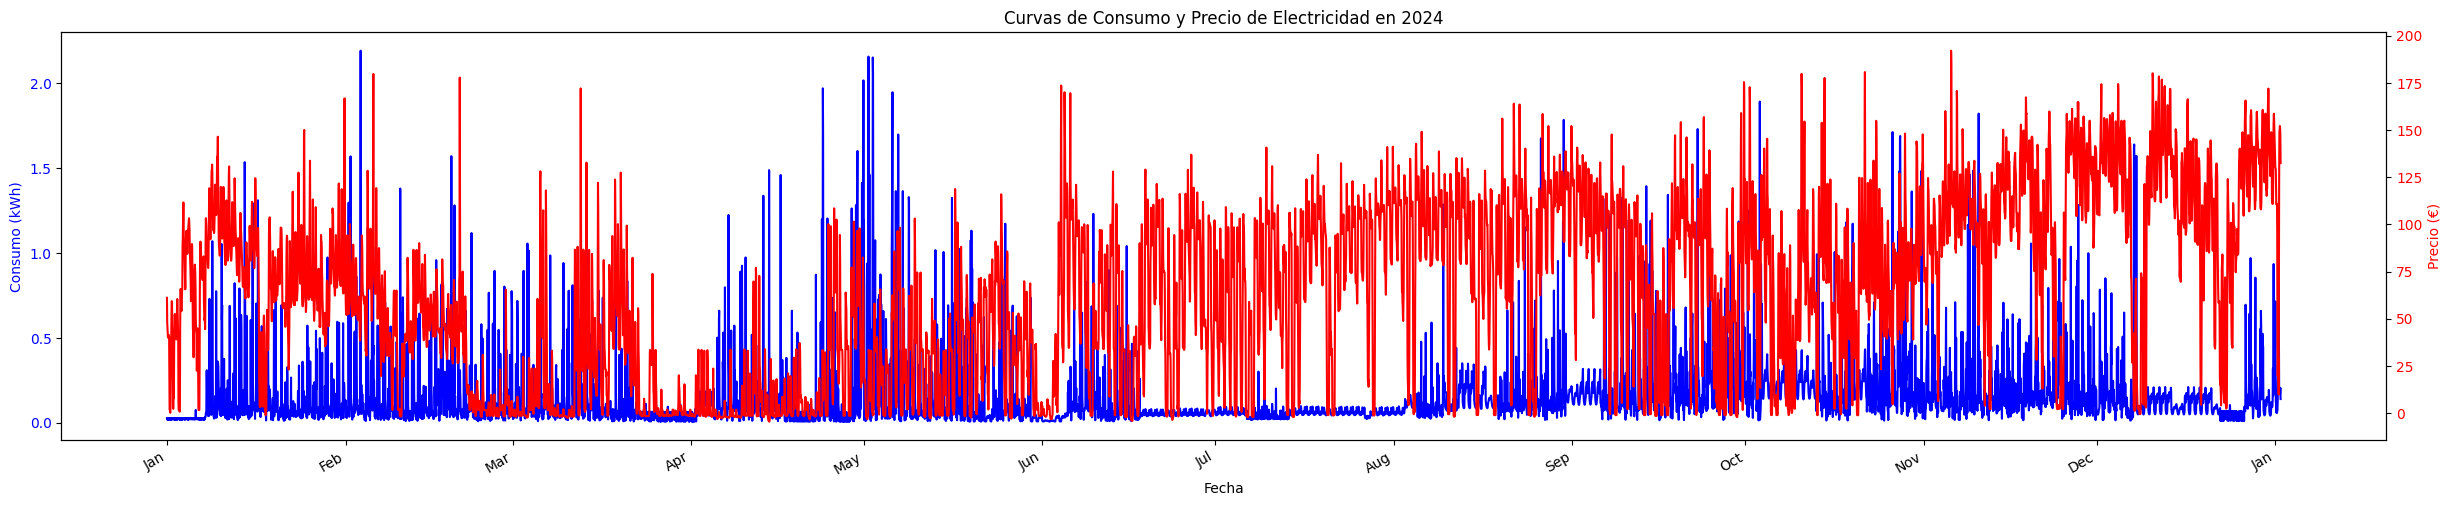

In [ ]:
import matplotlib.dates as mdates

# Cargar el nuevo dataset
file_path = "../data/datos_completos_limpios.csv" 
df_new = pd.read_csv(file_path)

# Convertir 'datetime' a formato datetime para graficar correctamente
df_new['datetime'] = pd.to_datetime(df_new['datetime'])

# Crear la figura y el eje principal
fig, ax1 = plt.subplots(figsize=(30, 6))

# Graficar la curva de consumo en el eje izquierdo
ax1.plot(df_new['datetime'], df_new['consumo_kWh'], color='blue', label='Consumo (kWh)')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Consumo (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear un segundo eje Y para la curva de precio
ax2 = ax1.twinx()
ax2.plot(df_new['datetime'], df_new['precio'], color='red', label='Precio (€)')
ax2.set_ylabel('Precio (€)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Formatear el eje X para que muestre solo los meses
ax1.xaxis.set_major_locator(mdates.MonthLocator())  # Ubicar ticks en cada mes
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Formato 'Ene', 'Feb', etc.

# Ajustar la presentación
plt.title('Curvas de Consumo y Precio de Electricidad en 2024')
fig.autofmt_xdate()  

# Mostrar la gráfica
plt.show()


Suavizar datos con media móvil de 8 horas

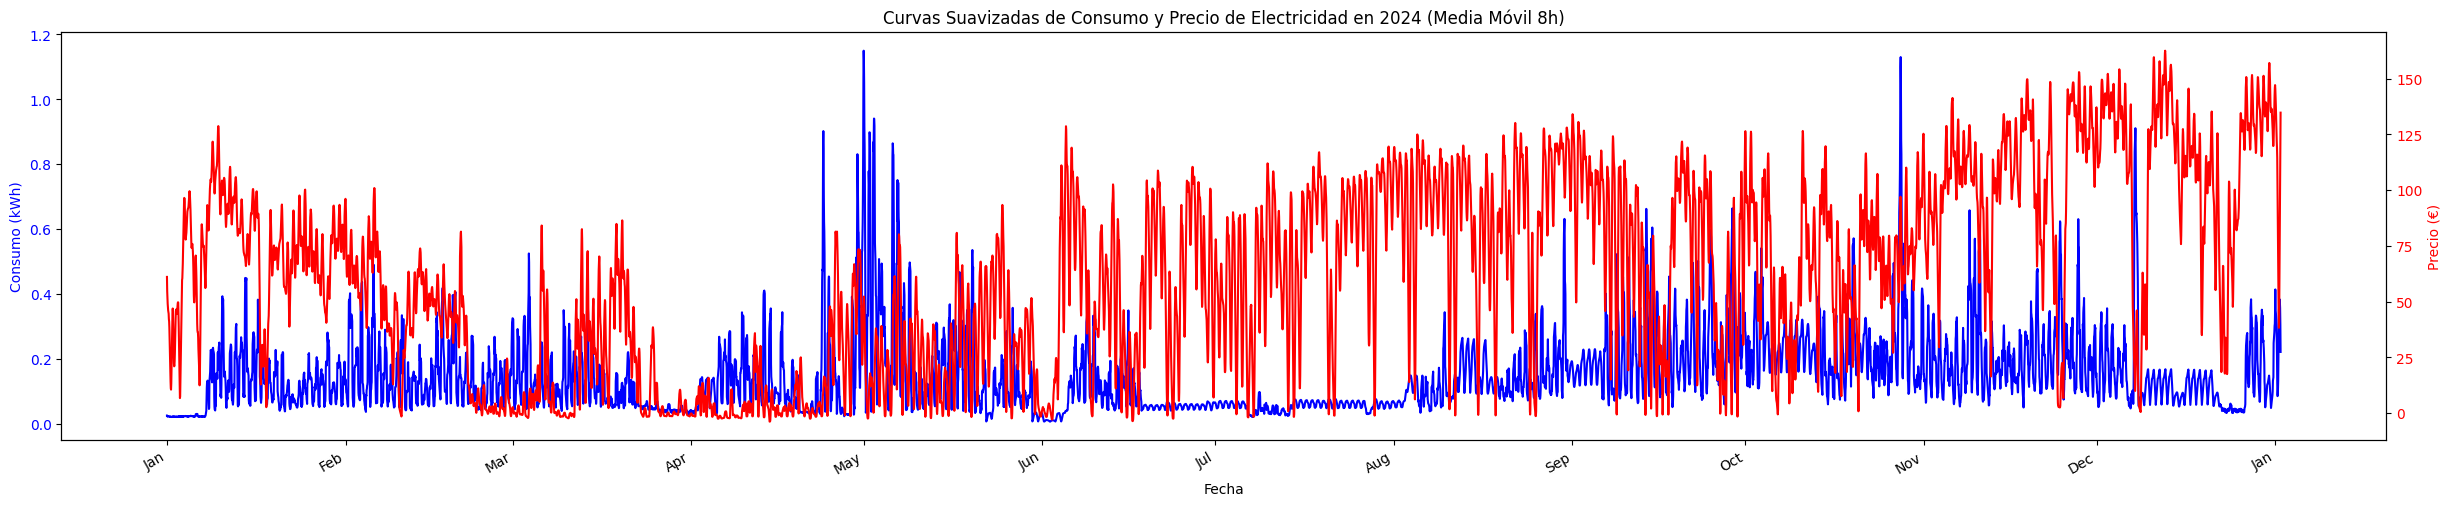

In [25]:
# Aplicar suavizado con media móvil de 8 horas
df_new['Consumo Suavizado'] = df_new['consumo_kWh'].rolling(window=8, min_periods=1).mean()
df_new['Precio Suavizado'] = df_new['precio'].rolling(window=8, min_periods=1).mean()

# Crear la figura y el eje principal
fig, ax1 = plt.subplots(figsize=(30, 6))

# Graficar la curva de consumo suavizada en el eje izquierdo
ax1.plot(df_new['datetime'], df_new['Consumo Suavizado'], color='blue', label='Consumo Suavizado (kWh)')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Consumo (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear un segundo eje Y para la curva de precio suavizada
ax2 = ax1.twinx()
ax2.plot(df_new['datetime'], df_new['Precio Suavizado'], color='red', label='Precio Suavizado (€)')
ax2.set_ylabel('Precio (€)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Formatear el eje X para que muestre solo los meses
ax1.xaxis.set_major_locator(mdates.MonthLocator())  # Ubicar ticks en cada mes
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Formato 'Ene', 'Feb', etc.

# Ajustar la presentación
plt.title('Curvas Suavizadas de Consumo y Precio de Electricidad en 2024 (Media Móvil 8h)')
fig.autofmt_xdate()  # Rotar etiquetas del eje X para mejor visualización

# Mostrar la gráfica
plt.show()


In [19]:
try:
    df_clean.to_csv('../data/datos_completos_limpios.csv', index=False)
    print("Archivo guardado exitosamente.")
except Exception as e:
    print(f"Error al guardar el archivo: {e}")

Archivo guardado exitosamente.
